# Lab 2: cleaning operations practice with the Adult dataset
In this lab, we will practice what we learned in the clearning operations lab, but now we use a larger dataset, __Adult__, which we already used in the previous lab . We start by loading the data as we have done before, as well as the necessary libraries. We will look at how to generate train/validation/test partitions, as well as how to do some cleaning of outliers on those, or balancing of training sets.  We will also look at how to assess the problem of missing values and how to impute those by a couple of techniques.  


In [1]:
import pandas as pd
import numpy as np
#pd.set_option('max_rows', 15)
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
print("Vis setup Complete")
print("Setup complete.")

Vis setup Complete
Setup complete.


## Loading the data

Now we begin by loading the data as we have done before and printing the `.head()` and `.tail()` to inspect the data.  Also produce a `countplot` of the target variable _income_ to observe the distribution of classes. Load the data as the _Adult_data_ data frame.  We will use that through the lab.

             filename  original_size  compressed_size  compression_ratio  \
0    dailymail_10.txt           4456             2126           0.522890   
1   dailymail_100.txt           3694             1849           0.499459   
2  dailymail_1002.txt            867              511           0.410611   
3  dailymail_1004.txt            671              433           0.354694   
4  dailymail_1006.txt            640              410           0.359375   

   newspaper  
0  dailymail  
1  dailymail  
2  dailymail  
3  dailymail  
4  dailymail  
             filename  original_size  compressed_size  compression_ratio  \
5217  thetimes_95.txt           1088              633           0.418199   
5218  thetimes_96.txt            849              528           0.378092   
5219  thetimes_97.txt            759              485           0.361001   
5220  thetimes_98.txt           1019              599           0.412169   
5221  thetimes_99.txt            704              446           0.366477 

<Axes: xlabel='count', ylabel='newspaper'>

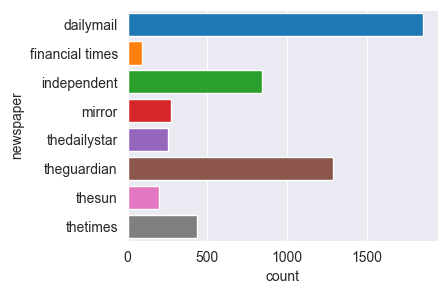

In [19]:
#designate the path where you saved your Iris data
newspaper_data_path = "newspaper_data.csv"

#Load the data using pandas read_csv function. This will generate a data frame we will use through the lab.
newspaper_data = pd.read_csv(newspaper_data_path)
# create a new column to confirm the newspaper name
newspaper_data['newspaper'] = newspaper_data['filename'].str.extract('(.*)_', expand=False)

#Show the first and last few records to check data is loading correctly
print(newspaper_data.head())
print(newspaper_data.tail())

# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(4, 3))
#Show distribution of the class on whole dataset
sns.countplot(y= 'newspaper', data=newspaper_data, saturation= 1, hue= "newspaper")

As in the previous lab, we specify the columns which are: "age", "workclass", "fnlwgt", "education",  "educational-num", "marital-status", "occupation", "relationship", "race", "gender", "capital-gain", "capital-loss", "hours-per-week", "native-country".

In [22]:
COLUMNS = ["newspaper", "original_size", "compressed_size", "compression_ratio"]

We will also specify two lists,  one which contains the __categorical columns__, and one which contains the __numeric columns__ of interest.   The categorical columns of interest are: "workclass", "education", "marital-status", "occupation","relationship", "race", "gender", "native-country".  The numeric columns are: "age", "education-num", "capital-gain", "capital-loss", "hours-per-week". We will exclude _fnlwgt_ as it is not a particularly useful variable and we will see this soon. 

In [23]:
cat_columns = ["newspaper"]
numeric_columns = ["original_size", "compressed_size", "compression_ratio"]

We can start by creating a `boxplot` of the `adult_data` (which will include the numeric variables only in it by default. What can we see in it?  Is there any problematic variables? 

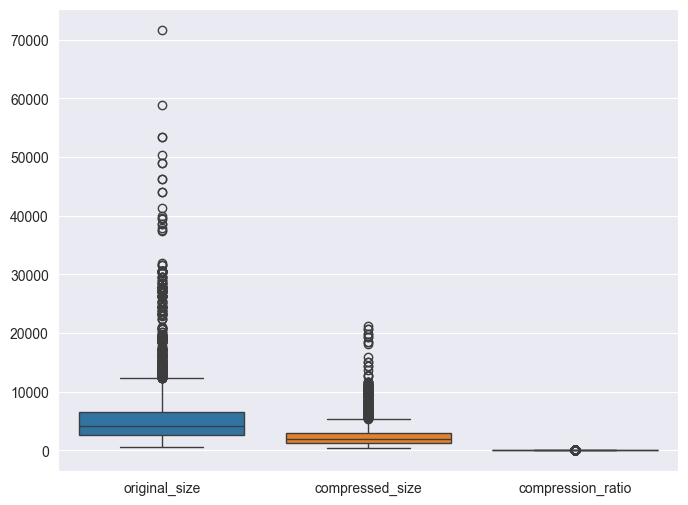

In [25]:
plt.figure(figsize=(8,6))
sns.boxplot(data=newspaper_data)
plt.show()

We can now designate our X or input variables.   Once assigned look at the `.head()` of X. 

In [27]:
#Designate the continuous input features as X
X= newspaper_data[numeric_columns]
X.head()

,original_size,compressed_size,compression_ratio
0,4456,2126,0.522890
1,3694,1849,0.499459
2,867,511,0.410611
3,671,433,0.354694
4,640,410,0.359375


Now designate the outcome or target variable as _y_ and look at the `.head() to see what we get.

In [28]:
#Designate the outcome or target variable as y
y = newspaper_data.newspaper
y.head()

0    dailymail
1    dailymail
2    dailymail
3    dailymail
4    dailymail
Name: newspaper, dtype: object

## Sampling (train/validation/test)

First, let us divide the Adult dataset into train/validation/test partitions.  We first designated 20% for a test partition, call it _test_X_.  The remainder we can call _part1_X_ as a first partition to be later subdivided.  We then subdivide the partition _part1_X_ into train/validate.  For the second partition we will make we also designate 20% as the validation set. We will not use the test set until the final stage of testing the model, but we can use the validation set to test any intermediary decision as we later build models for classification.

So we start by sampling and dividing the original X,y into the part1_X/test_X and part1_y/test_y with the `train_test_split` method and looking at each with the `describe()` method.

In [44]:
from sklearn.model_selection import train_test_split

# Without stratification divide into first partition and test set.
part1_X,test_X, part1_y, test_y= train_test_split (X,y, test_size=0.3,random_state=1)

print(part1_X.describe())
print(test_X.describe())

       original_size  compressed_size  compression_ratio
count    3655.000000      3655.000000        3655.000000
mean     5270.594802      2340.848427           0.516917
std      5133.432160      1940.739605           0.067433
min       504.000000       324.000000           0.288355
25%      2530.000000      1242.000000           0.490651
50%      4085.000000      1907.000000           0.523132
75%      6375.000000      2878.000000           0.555587
max     71627.000000     21252.000000           0.821324
       original_size  compressed_size  compression_ratio
count    1567.000000      1567.000000        1567.000000
mean     5377.709636      2383.286535           0.517419
std      5283.105267      1989.975348           0.067056
min       505.000000       317.000000           0.295019
25%      2572.500000      1272.000000           0.489265
50%      4061.000000      1919.000000           0.524432
75%      6537.000000      2962.500000           0.558099
max     58926.000000     19785.

Now we sample by dividing the _part1_X_ partition into a Train/Validation partition and we also inspect it with `.describe()`. We can compare _train_X, val_X and test_X_, the three sets we have obtained.

In [53]:
# Without stratification divide the first partition 
train_X,val_X, train_y, val_y= train_test_split (part1_X,part1_y, test_size=0.3,random_state=1)

print("Train set description \n", train_X.describe())
print("Validation set description \n",val_X.describe())
print("Test set description \n",test_X.describe())

Train set description 
        original_size  compressed_size  compression_ratio
count    2558.000000      2558.000000        2558.000000
mean     5238.351056      2324.908913           0.516175
std      5231.798167      1951.661456           0.067696
min       505.000000       328.000000           0.288355
25%      2510.500000      1232.250000           0.490250
50%      4034.000000      1874.500000           0.521975
75%      6332.750000      2854.500000           0.554820
max     71627.000000     20628.000000           0.821324
Validation set description 
        original_size  compressed_size  compression_ratio
count    1097.000000      1097.000000        1097.000000
mean     5345.781222      2378.016408           0.518647
std      4897.893460      1915.397820           0.066816
min       504.000000       324.000000           0.306043
25%      2600.000000      1277.000000           0.492942
50%      4281.000000      1965.000000           0.524926
75%      6511.000000      2947.0000

## Outlier detection

We start now looking at outliers. For the purpose of looking at outliers, let us consider the continous columns we have already defined only so X can be equal to the CONTINUOUS_COLUMNS of the data frame. We can create a new train_X wich we can call train_OL_X with the CONTINUOUS_COLUMNS only.

In [91]:
#Designate the continuous input features as train_OL_X
train_OL_X= train_X[numeric_columns]
train_OL_X.shape
train_OL_X.head()

,original_size,compressed_size,compression_ratio
4298,7337,3609,0.508110
4543,6404,2982,0.534354
2888,3070,1507,0.509121
3308,4361,2122,0.513414
869,8244,3949,0.520985


## Outlier detection

We now try to detect outliers, first with the DBSCAN algorithm.  Since this file is rather large we do not print the objects with their allocation (outliers designated as -1, or not outliers) but we can print the total number of outliers found.  We can also alter the parameters `min_samples` and `eps` to see the effect on the outliers detected. Once you have the code working, experiment with the algorithm parameters to get a not too large number of outliers. We can apply this on the train data only, but to the one with continous columns, i.e. train_OL_X.

In [135]:
#import the implementation of this algorihm from sklearn
from sklearn.cluster import DBSCAN

#Use the algorithm for outlier detection, the return in clusters will show the membership of each point
#Any point labelled as -1 is an outlier

outlier_detection = DBSCAN(min_samples = 2, eps = 70, leaf_size= 30)
clusters = outlier_detection.fit_predict(train_OL_X)

#Count total number of outliers as count of those labelled as -1
TotalOutliers=list(clusters).count(-1)

#print (clusters)
print("Total number of outliers identified is: ",TotalOutliers)



Total number of outliers identified is:  244


In [112]:
print(train_OL_X.dtypes)

original_size          int64
compressed_size        int64
compression_ratio    float64
dtype: object


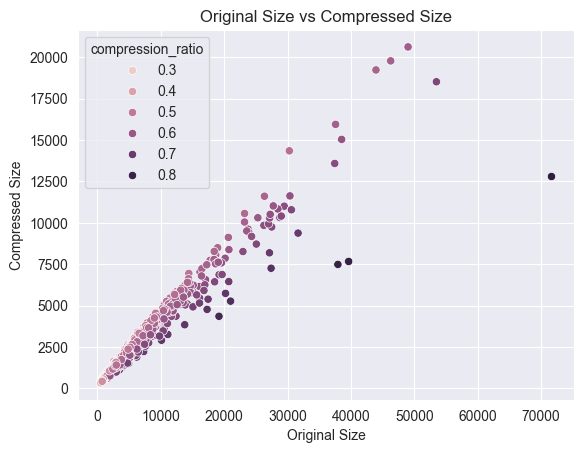

InvalidIndexError: (slice(None, None, None), 0)

In [124]:
# Create a scatter plot of original_size vs compressed_size, with color representing compression_ratio
sns.scatterplot(x=train_OL_X['original_size'], y=train_OL_X['compressed_size'], hue=train_OL_X['compression_ratio'])
# Add labels and title
plt.xlabel('Original Size')
plt.ylabel('Compressed Size')
plt.title('Original Size vs Compressed Size')

# Show the plot
plt.show()


# Plot the data points with colors representing the cluster assignments
plt.scatter(train_OL_X[:,0], train_OL_X[:,1], c=clusters)
plt.scatter(train_OL_X[['original_size']].values, train_OL_X[['compressed_size']].values, c=clusters)
plt.title('DBSCAN Outlier Detection Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()




We can now create a mask or filter to ensure only those rows that are not outliers are retained in a new data frame that we can later use for classification.  Let us create a new output variable _y1_ and input set of variables _X1_ which contain a filtered version of the original data frame. For this, we can create a mask which takes the value of `clusters!= -1`.  This will be a boolean array which we can then use to filter _y_ into a new version _y1_, and similarly _X_ into a new version _X1_.  Check the shape of the new X and y with `.shape` to see the size of each. The amount of rows should be equal to the rows in the original data frame minus the rows that were designated as outliers. Note that we need to filter the data frame that contains all the columns (_train_X, train_y_), and not just the numeric ones, as all columns will be needed for the classification algorithms.

In [70]:
# select all rows that are not outliers and create a boolean mask
mask = clusters != -1
# Apply mask to y and check shape
y1= train_y[mask]
print (y1.shape)

#Apply mask to X and check shape 
X1=train_X[mask]
print(X1.shape)

(2314,)
(2314, 3)


Let us now do similarly but using the `IsolationForest` algorithm.  Again, investigate the parameters to understand how many outliers are found as we change those paramaters.

In [128]:
#import the implementation of this algorihm from sklearn
from sklearn.ensemble import IsolationForest

#Use the algorithm for outlier detection, then use it to predict each point
#Any point labelled as -1 is an outlier
clf = IsolationForest(max_samples=500, random_state = 1, contamination= 0.01)
preds = clf.fit_predict(train_OL_X)
#print(preds)
totalOutliers=0
for pred in preds:
    if pred == -1:
        totalOutliers=totalOutliers+1
print("Total number of outliers identified is: ",totalOutliers)


Total number of outliers identified is:  26


Again, we can create a mask or filter to ensure only those rows that are not outliers are retained in a new data frame that we can later use for classification.  Let us create a new output variable _y2_ and input set of variables _X2_ which contain a filtered version of the original data frame, this time with the isolation algorithm filter. For this, we can create a mask which takes the value of `preds!= -1`.  This will be a boolean array which we can then use to filter _train_y_ into a new version _y2_, and similarly _Train_X_ into a new version _X2_.  Again check the shape of the new X and y with `.shape` to see the size of each. 

In [126]:
# select all rows that are not outliers and create a boolean mask
mask = preds != -1
# Apply mask to y and check shape
y2= train_y[mask]
print (y2.shape)

#Apply mask to X and check shape 
X2=train_X[mask]
print(X2.shape)

(2532,)
(2532, 3)


Finally, we can try to run the LocalOutlierFactor algorithm on the newspaper data.  Once this is done, if you wish to visualise the outliers, you could produce a graph similar to the one produced in the _CleaningExamples_ lab, but this time plot for example _age_ versus _educational_num_ (columns 0 and 1). You may not need to use limits on the x and y axis for this plot, or you will need to adapt them to the right values. 

Number of predicted outliers: 26


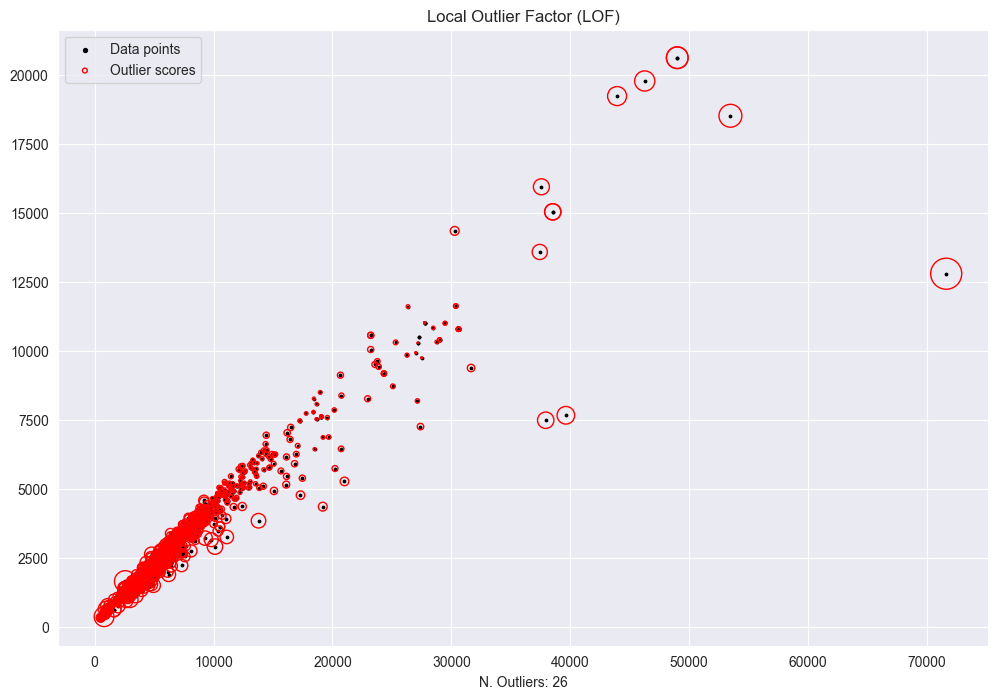

In [137]:
from sklearn.neighbors import LocalOutlierFactor
np.random.seed(42)

# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.01)

# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(train_OL_X)

#print ("Predicted outliers: \n",y_pred)

#Calculate number of outliers
outlierN = len([i for i in y_pred if i == -1])
print ("Number of predicted outliers:",outlierN)


#Let us see graphically how the outliers are identified
#Use outlier scores calculated by the algorithm to plot a circle around the outlier proportional to score.

X_scores = clf.negative_outlier_factor_

plt.figure(figsize=(12,8))
plt.title("Local Outlier Factor (LOF)")

#Convert the df to an array for the purpose of the scatterplot
Xol = train_OL_X.to_numpy()

#Use scatter 
plt.scatter(Xol[:, 0], Xol[:, 1], color='k', s=3, label='Data points')

# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(Xol[:, 0], Xol[:, 1], s=500 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
#plt.xlim((0, 14))
#plt.ylim((0, 6))
plt.xlabel("N. Outliers: %d" % (outlierN))
legend = plt.legend(loc='upper left')
legend.legend_handles[0]._sizes = [8]
legend.legend_handles[1]._sizes = [12]
plt.show()

Again, we filter to ensure only those rows that are not outliers are retained in a new data frame that we can later use for classification.  Let us create a new output variable _y3_ and input set of variables _X3_ which contain a filtered version of the original data frame, this time with the LOF algorithm filter, similar to the previous to cells. 

In [138]:
# select all rows that are not outliers and create a boolean mask
mask = y_pred != -1
# Apply mask to y and check shape
y3= train_y[mask]
print (y3.shape)

#Apply mask to X and check shape 
X3=train_X[mask]
print(X3.shape)

(2532,)
(2532, 3)


If you wish to save any of the dataframes you have created to load them elsewhere you can do that with the `.to_csv()` method.  You can pass inside as parameters the path and file name and `index = False` if you don't wish to save the index.  Alternatively, you can repeat the code above to get the data frame in a later lab.

In [143]:
#Save X3 to a file for later use if necessary
X3.to_csv("../Data_Mining/X3partition.csv", index = False)

## Balancing of the data

Now we will practice balancing the data.  We can apply balancing operations to the original training data, or we could apply it to any of the versions with outliers removed if we later decided that removing the outliers may be beneficial.  Let us use the original training data ignoring outlier removal for the time being. We can start by producing a count of how many rows are there for each label using the `value_counts()` method on the _train_y_ series.

In [18]:
train_y.value_counts()

<=50K    23805
>50K      7453
Name: income, dtype: int64

Now we will try to produce a balanced sample but instead of doing it from the whole file, as we do not want to balance the test data, we wil do it from the training data only, the _train_X_ data frame. First we need to concatanate the X and y part of the training data to apply balancing.  We can separate again later.   We can start by trying to upsample the minority class so they both have an equal number of samples.  We can look at the statistics of the upsampled data, together with the new value counts.

In [19]:
from sklearn.utils import resample

#The first thing is contatenate our training data back together.  
resampling = train_X.copy()
resampling['income']= train_y.values

# separate minority and majority classes
majority_class = resampling[resampling['income']=='<=50K']
minority_class = resampling[resampling['income']=='>50K']

# Upsample minority class
minority_upsampled = resample(minority_class, 
                                 replace=True,     # sample with replacement
                                 n_samples=23805,     # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
upsampled = pd.concat([majority_class, minority_upsampled])

# Show dataset statistics
print(upsampled.describe())
 
# Display new class counts
upsampled.income.value_counts()



                age        fnlwgt  educational-num  capital-gain  \
count  47610.000000  4.761000e+04     47610.000000  47610.000000   
mean      40.557446  1.892139e+05        10.581601   2173.527893   
std       12.986638  1.058789e+05         2.612961  11006.047986   
min       17.000000  1.349200e+04         1.000000      0.000000   
25%       31.000000  1.175830e+05         9.000000      0.000000   
50%       40.000000  1.769980e+05        10.000000      0.000000   
75%       49.000000  2.364248e+05        13.000000      0.000000   
max       90.000000  1.490400e+06        16.000000  99999.000000   

       capital-loss  hours-per-week  
count  47610.000000    47610.000000  
mean     119.122096       42.214556  
std      470.885744       12.217361  
min        0.000000        1.000000  
25%        0.000000       40.000000  
50%        0.000000       40.000000  
75%        0.000000       50.000000  
max     4356.000000       99.000000  


<=50K    23805
>50K     23805
Name: income, dtype: int64

We may now want to produce another `countplot` to compare the class imbalance.

<Axes: xlabel='income', ylabel='count'>

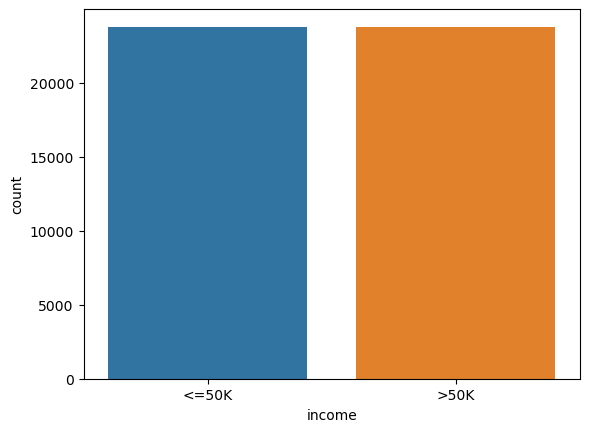

In [20]:
#Show distribution of the class on whole dataset
sns.countplot(x= 'income', data=upsampled)

Additionally, we may produce a `stripplot` to understand how the data was distributed for the two classes in the original data frame, _Adult_data_ and then another one for how it is distributed in the new upsampled data for comparison. 

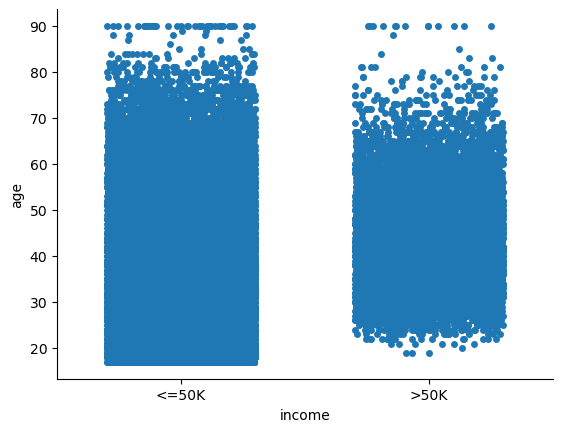

In [21]:
sns.stripplot(x=Adult_data['income'],y=Adult_data['age'],data=Adult_data, jitter=0.3)
sns.despine()

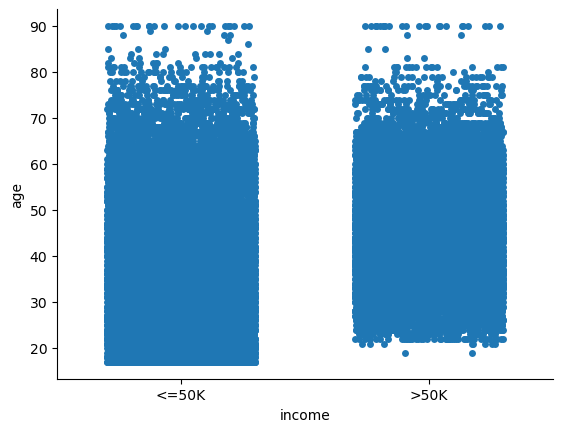

In [22]:
sns.stripplot(x=upsampled['income'],y=upsampled['age'],data=upsampled, jitter=0.3)
sns.despine()

Now, we do similarly, but this time we downsample the majority class to produce a reduced balanced dataset.  We look at value counts and after we can produce a `countplot` to look at the distribution of values in the classes.

In [23]:
# Downsample majority class
majority_downsampled = resample(majority_class, 
                                 replace=False,    # sample without replacement
                                 n_samples=7453,     # to match minority class
                                 random_state=123) # reproducible results
    
# Combine minority class with downsampled majority class
downsampled = pd.concat([majority_downsampled, minority_class])
 
# Display new class counts
downsampled.income.value_counts()

<=50K    7453
>50K     7453
Name: income, dtype: int64

<Axes: xlabel='income', ylabel='count'>

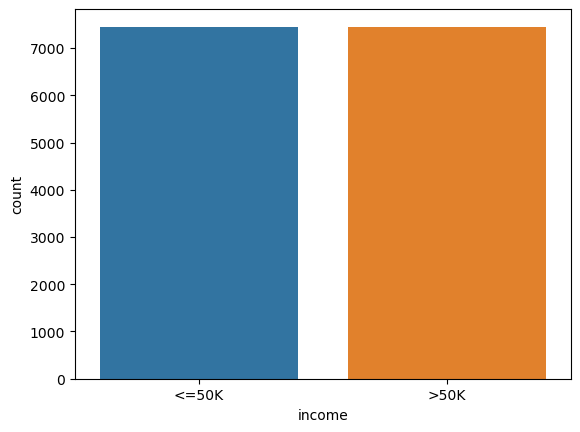

In [24]:
#Show distribution of the class on whole dataset
sns.countplot(x= 'income', data=downsampled)

Again a `stripplot` can show the distribution of points within the classes in the downsampled data frame.

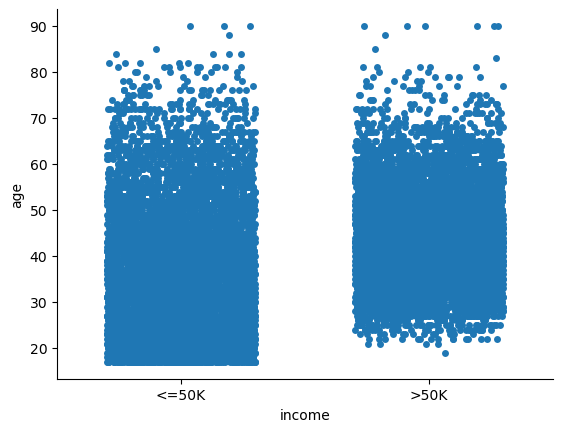

In [25]:
sns.stripplot(x=downsampled['income'],y=downsampled['age'],data=downsampled, jitter=0.3)
sns.despine()

Now you could chose to use either your dowsampled or upsampled training data as the data to classify.  For this you will need to divide the _X_ part (decision variables) from the _y_ part (target variable), before feeding to any classification algorithms. Attempt that for the upsampled data. 

In [26]:
#Designate the continuous input features as X
upsampled_X=upsampled[COLUMNS]
print(upsampled_X.head())
print("Shape of training data:",upsampled_X.shape,"\n")

#Designate the outcome or target variable as y
upsampled_y = upsampled.income
print(upsampled_y.head())
print("Shape of training data:",upsampled_y.shape,"\n")

       age         workclass  fnlwgt     education  educational-num  \
14072   48           Private  309212  Some-college               10   
34328   52  Self-emp-not-inc  240013       Masters               14   
41446   25           Private  233461    Assoc-acdm               12   
606     30           Private  101562       HS-grad                9   
42951   34           Private  174789     Bachelors               13   

           marital-status       occupation   relationship   race  gender  \
14072            Divorced  Exec-managerial  Not-in-family  White  Female   
34328  Married-civ-spouse            Sales        Husband  White    Male   
41446       Never-married     Tech-support  Not-in-family  White    Male   
606         Never-married     Adm-clerical  Not-in-family  White  Female   
42951       Never-married    Other-service  Not-in-family  White    Male   

       capital-gain  capital-loss  hours-per-week native-country  
14072             0             0              40

## Missing data

Now we will get to deal with missing data. First thing is to understand how missing data, if there is any, is represented in the dataset we are looking at. The distribution graphs we did in the previous lab for the Adult data frame showed that _occupation_, _workclass_ and _native_country_ appeared to have missing values represented as '?'.  We can start by replacing all values of _'?'_ in the data frame with _nan_, the representation of missing data in _numpy_. For this  the `.replace()` method can be used with the first parameter being what we want to replace, i.e. '?' and the second being what we want to replace it with, i.e. _nan_.  We need to make missing data consistently represented in the whole dataset so we apply this to the _Adult_data_ data frame.

In [27]:
from numpy import nan
Adult_data = Adult_data.replace('?', nan)

Now, we can count how many missing (i.e. nan) numbers there are in the data frame as a whole. Then how many there are in each column or variable.

In [28]:
# get the number of missing data points per column
missing_values_count = Adult_data.isnull().sum()

# look at the # of missing points in the  columns
print(missing_values_count[0:15])


age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64


We now start by removing all rows that contain a missing value.  How many rows are left?

In [29]:
# remove all the rows that contain a missing value
Adult_data.dropna()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


Difficulty (High): Finally, we look at how to impute the data.  However, we may need to use different methods for categorical and numeric data.  Let us create a `class` _DataFrameIputer_ which takes the 'TransformerMixin' class from scikit-learn  https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html and uses the mean values for numeric columns and the most frequent value for non-numeric columns.  After that, we can use the new class to transform our data and input the missing values in the process.  

In [30]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):
        # Find most common value with value_counts() which returns 
        # counts in descending order so that the first element is the most frequently-occurring element.
        self.fill = pd.Series([X[c].value_counts().index[0]
            #Use that if type is object otherwise use mean                   
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


#Define the data to be filled as X, we can pass the whole data frame and apply our new class
X = Adult_data
xt = DataFrameImputer().fit_transform(X)

print('before...')
#Let us see missing value for the train data before
missing_val_count_by_column = (X.isnull().sum())
print('Missing columns for the Train data:\n',missing_val_count_by_column[missing_val_count_by_column>0])

#and after
print('after...')
missing_val_count_by_column = (xt.isnull().sum())
print('Missing columns for the Train data:\n',missing_val_count_by_column[missing_val_count_by_column>0])




before...
Missing columns for the Train data:
 workclass         2799
occupation        2809
native-country     857
dtype: int64
after...
Missing columns for the Train data:
 Series([], dtype: int64)


Note that we could have used imputation only on the training part of the data frame, although if the classification algorithm we are going to use does not accept missing data, then we may need to apply the imputation on the whole dataset as we just did.  

Now that is all for this lab!!! We have created a number of data frames we may use in later labs for classification so make sure you save your work ready for re-use later. 